# Quadtree interpolation
In this notebook, I (Olivia) seek to implement the full interpolation operation for the HPS quadtree from the Chebyshev to Uniform grids. I make the simplifying assumption that the uniform grid contains an integer number of pixels per leaf, which will allow us to re-use the interpolation matrix across every leaf.

In [1]:
import os
import jax
import jax.numpy as jnp
from scipy.io import savemat
import matplotlib.pyplot as plt

import logging
logging.basicConfig(
    format="%(asctime)s.%(msecs)03d:jaxhps: %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.DEBUG
)

from examples.wave_scattering_utils import (
    solve_scattering_problem,
    load_SD_matrices,
    get_uin,
)
from examples.scattering_potentials import (
    q_gaussian_bumps,
)
from examples.plotting_utils import plot_field_for_wave_scattering_experiment

jax.config.update("jax_default_device", jax.devices("gpu")[0])
jax.config.update("jax_enable_x64", True)

2025-06-20 13:47:06.267:jaxhps: DEBUG - Creating converter from 7 to 5
2025-06-20 13:47:06.272:jaxhps: DEBUG - Creating converter from 5 to 7
2025-06-20 13:47:06.275:jaxhps: DEBUG - Creating converter from 7 to 5
2025-06-20 13:47:06.277:jaxhps: DEBUG - Creating converter from 5 to 7


In [2]:
from jaxhps import (
    DiscretizationNode2D,
    Domain,
    PDEProblem,
    upward_pass_subtree,
    downward_pass_subtree,
    local_solve_chunksize_2D,
)
from jaxhps.local_solve import local_solve_stage_uniform_2D_ItI
from jaxhps.merge import merge_stage_uniform_2D_ItI
from jaxhps.down_pass import down_pass_uniform_2D_ItI
from timeit import default_timer
from examples.wave_scattering_utils import (
    get_DtN_from_ItI,
    setup_scattering_lin_system,
    get_uin_and_normals,
    get_uin,
    get_scattering_uscat_impedance,
)
from src.jaxhps import (
    Domain as MyDomain,
    DiscretizationNode2D as MyDiscretizationNode2D
)
from src.jaxhps._grid_creation_2D import rearrange_indices_ext_int as rearrange_indices_ext_int_2D
from jaxhps.quadrature import barycentric_lagrange_interpolation_matrix_2D, chebyshev_points
INTERP_BATCH_SIZE = 20

## Basic setup

In [3]:
# Basic problem dimensions
k_str = "20"
k = float(k_str)

L = 4
p = 12 # chebyshev order
pm2 = p-2 # gauss-legendre order
n = 192
nside = 2**L
n_per_leaf = n // (2**L)

q_fn_handle = q_gaussian_bumps
domain_bounds = jnp.array([-1., 1., -1., 1.])
source_dirs = jnp.linspace(0, 2*jnp.pi, 30)

In [4]:
grid_unif_x = jnp.linspace(-1, 1, n, endpoint=False)
grid_unif_y = jnp.linspace(-1, 1, n, endpoint=False) # [::-1]
grid_unif_xy = jnp.array(jnp.meshgrid(grid_unif_x, grid_unif_y, indexing="ij")).transpose(1,2,0).reshape(-1,2)

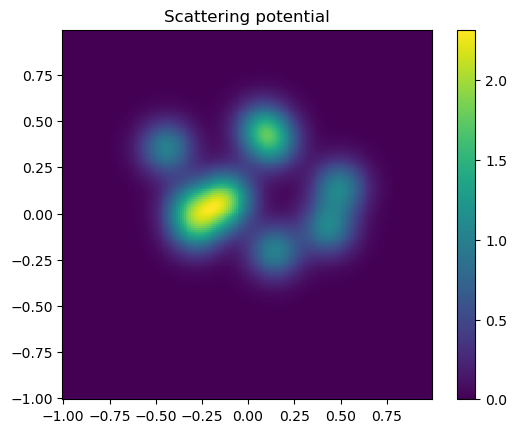

In [5]:
q_val = q_fn_handle(grid_unif_xy).reshape(n,n)
plt.title(f"Scattering potential")
plt.pcolormesh(
    grid_unif_x,
    grid_unif_y,
    jnp.real(q_val[...]),
    cmap="viridis",
)
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

In [6]:
# Load S and D matrices for the boundary integral equation
S_D_matrices_fp = os.path.join(
    "data/wave_scattering/SD_matrices",
    f"SD_k{k_str}_n{pm2}_nside{nside}_dom1.mat"
)
S, D = load_SD_matrices(S_D_matrices_fp)

## Wave scattering solution

In [18]:
# copy-and-pasted version of solve_scattering_problem so I can inspect intermediate states
q_fn = q_fn_handle

logging.info("solve_scattering_problem: Creating tree...")
xmin, xmax, ymin, ymax = domain_bounds
root = MyDiscretizationNode2D(
    xmin=float(xmin), xmax=float(xmax), ymin=float(ymin), ymax=float(ymax)
)

domain = MyDomain(p=p, q=p-2, root=root, L=L)

# Evaluate the coefficients and source term for the wave scattering problem
d_xx_coeffs = jnp.ones_like(domain.interior_points[:, :, 0])
d_yy_coeffs = jnp.ones_like(domain.interior_points[:, :, 0]) # [:, :, 1]?
i_term = k**2 * (1 + q_fn(domain.interior_points))
logging.debug("solve_scattering_problem: i_term shape: %s", i_term.shape)

uin_evals = get_uin(k, domain.interior_points, source_dirs)

source_term = (
    -1 * (k**2) * q_fn(domain.interior_points)[..., None] * uin_evals
)
logging.debug(
    "solve_scattering_problem: source_term shape: %s", source_term.shape
)

logging.debug("solve_scattering_problem: S device: %s", S.devices())

t = PDEProblem(
    domain=domain,
    D_xx_coefficients=d_xx_coeffs,
    D_yy_coefficients=d_yy_coeffs,
    I_coefficients=i_term,
    source=source_term,
    use_ItI=True,
    eta=k,
)
logging.info(f"Finished setting up the PDEProblem object")
t_0 = default_timer()

# Determine whether we need to use fused functions or can fit everything on the
n_leaves = domain.n_leaves
chunksize = local_solve_chunksize_2D(p, jnp.complex128)

bool_use_recomp = chunksize < n_leaves

if bool_use_recomp:
    T_ItI = upward_pass_subtree(
        pde_problem=t,
        subtree_height=6,
        compute_device=jax.devices()[0],
        host_device=jax.devices()[0],
    )
else:
    logging.info(f"Starting local solve")
    Y_arr, T_arr, v_arr, h_arr = local_solve_stage_uniform_2D_ItI(
        pde_problem=t,
        host_device=jax.devices()[0],
        device=jax.devices()[0],
    )
    logging.info("Finished local solve; starting merge stage")
    S_arr_lst, g_tilde_lst, T_ItI = merge_stage_uniform_2D_ItI(
        T_arr=T_arr,
        h_arr=h_arr,
        l=domain.L,
        device=jax.devices()[0],
        host_device=jax.devices()[0],
        return_T=True,
    )
    logging.info(f"Finished merge stage")

T_DtN = get_DtN_from_ItI(T_ItI, t.eta)
logging.info(f"Got DtN from ItI")

logging.info(
    "solve_scattering_problem: Solving boundary integral equation..."
)

if jax.devices()[0] not in S.devices():
    S = jax.device_put(S, jax.devices()[0])
    D = jax.device_put(D, jax.devices()[0])
    bool_delete_SD = True
else:
    bool_delete_SD = False
incoming_imp_data = get_scattering_uscat_impedance(
    S=S,
    D=D,
    T=T_DtN,
    source_dirs=source_dirs,
    bdry_pts=t.domain.boundary_points,
    k=k,
    eta=k,
)

logging.info("Finished calculating incoming impedance data")

# Delete exterior matrices we no longer need
T_ItI.delete()
T_DtN.delete()
if bool_delete_SD:
    S.delete()
    D.delete()
logging.info("Deleted exterior matrices; starting to propagate the impedance data")

# Propagate the resulting impedance data down to the leaves
if bool_use_recomp:
    uscat_soln = downward_pass_subtree(
        pde_problem=t,
        boundary_data=incoming_imp_data,
        subtree_height=6,
        compute_device=jax.devices()[0],
        host_device=jax.devices()[0],
    )
else:
    uscat_soln = down_pass_uniform_2D_ItI(
        boundary_data=incoming_imp_data,
        S_lst=S_arr_lst,
        g_tilde_lst=g_tilde_lst,
        Y_arr=Y_arr,
        v_arr=v_arr,
        device=jax.devices()[0],
        host_device=jax.devices()[0],
    )

# Interpolate the solution onto a regular grid with n points per dimension
logging.info(
    "solve_scattering_problem: Interpolating solution onto regular grid..."
)

# Original version
# xvals_reg = jnp.linspace(xmin, xmax, n)
# yvals_reg = jnp.linspace(ymin, ymax, n)
# Modified version so the spacing within each leaf is consistent
xvals_reg = jnp.linspace(xmin, xmax, n, endpoint=False)
yvals_reg = jnp.linspace(ymin, ymax, n, endpoint=False)

n_src = source_dirs.shape[0]

uscat_regular = jnp.zeros(
    (n, n, n_src), dtype=jnp.complex128, device=jax.devices("cpu")[0]
)

# Do the interpolation from HPS to regular grid in batches of size INTERP_BATCH_SIZE
# along the source dimension
for i in range(0, n_src, INTERP_BATCH_SIZE):
    chunk_start = i
    chunk_end = min((i + INTERP_BATCH_SIZE), n_src)
    logging.debug(
        "solve_scattering_problem: Interpolating chunk i=%s, %s:%s",
        i,
        chunk_start,
        chunk_end,
    )
    uscat_i = uscat_soln[..., chunk_start:chunk_end]
    logging.debug(
        "solve_scattering_problem: uscat_i.devices()=%s", uscat_i.devices()
    )
    chunk_i, target_pts = domain.interp_from_interior_points(
        samples=uscat_i, eval_points_x=xvals_reg, eval_points_y=yvals_reg
    )

    chunk_i = jax.device_put(chunk_i, jax.devices("cpu")[0])
    uscat_regular = uscat_regular.at[..., chunk_start:chunk_end].set(
        chunk_i
    )

uscat_regular.block_until_ready()
logging.info(f"Finishing...")

t_1 = default_timer() - t_0
# return uscat_regular, target_pts, t_1
print(f"Finished in {t_1:.2f}s")

2025-06-20 14:53:15.280:jaxhps: INFO - solve_scattering_problem: Creating tree...
2025-06-20 14:53:15.780:jaxhps: DEBUG - solve_scattering_problem: i_term shape: (256, 144)
2025-06-20 14:53:15.785:jaxhps: DEBUG - solve_scattering_problem: source_term shape: (256, 144, 30)
2025-06-20 14:53:15.786:jaxhps: DEBUG - solve_scattering_problem: S device: {CudaDevice(id=0)}
2025-06-20 14:53:15.808:jaxhps: INFO - Finished setting up the PDEProblem object
2025-06-20 14:53:15.810:jaxhps: INFO - Starting local solve
2025-06-20 14:53:15.811:jaxhps: DEBUG - local_solve_stage_uniform_2D_ItI: started. device=cuda:0
2025-06-20 14:53:15.825:jaxhps: INFO - Finished local solve; starting merge stage
2025-06-20 14:53:15.826:jaxhps: DEBUG - merge_stage_uniform_2D_ItI: started. device=cuda:0
2025-06-20 14:53:15.827:jaxhps: DEBUG - merge_stage_uniform_2D_ItI: T_arr.shape = (256, 40, 40)
2025-06-20 14:53:15.923:jaxhps: INFO - Finished merge stage
2025-06-20 14:53:15.927:jaxhps: INFO - Got DtN from ItI
2025-06-2

Finished in 73.30s


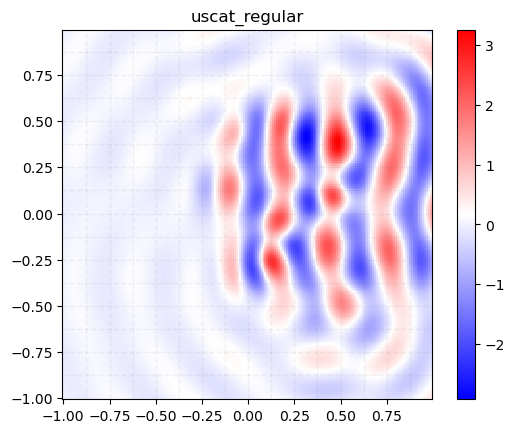

In [8]:
src_idx = 0
show_leaves = True
fig, ax = plt.subplots(1)
ax.set_title(f"uscat_regular")
cb = ax.pcolormesh(
    xvals_reg,
    yvals_reg,
    jnp.real(uscat_regular[..., src_idx]),
    cmap="bwr",
)
if show_leaves:
    for li in range(1, 2**L):
        ax.axvline(-1 + 2 * (li/2**L), color="gray", linestyle="dashed", linewidth=1, alpha=0.1)
        ax.axhline(-1 + 2 *(li/2**L), color="gray", linestyle="dashed", linewidth=1, alpha=0.1)
ax.set_aspect(1)
fig.colorbar(cb)
plt.show()

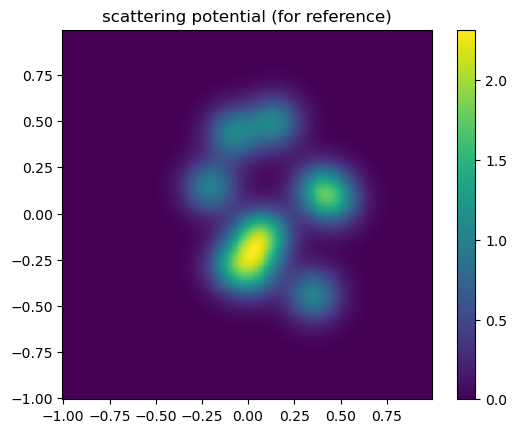

In [9]:
fig, ax = plt.subplots(1)
ax.set_title(f"scattering potential (for reference)")
cb = ax.pcolormesh(
    yvals_reg,
    xvals_reg,
    jnp.real(q_fn_handle(target_pts)[...]),
    cmap="viridis",
)

ax.set_aspect(1)
fig.colorbar(cb)
plt.show()

## Leaf reordering setup

In [10]:
def reorder_leaves_recursive_data(leaf_data: jax.Array, new_order: tuple=(3,2,0,1), L: int=None):
    """Recursively reorder the leaves in the requested order
    This function assumes that the provided data has the leaf index as the first axis.
    Suppose the inputs have children in labeled as [0,1,2,3]
        +-----+-----+-----+-----+
        |  0  |  1  |  2  |  3  |
        +-----+-----+-----+-----+
    This function will re-order the children within the flattened structure.
    For example, setting new_order=(3,2,0,1) would result in
        +-----+-----+-----+-----+
        |  3  |  2  |  0  |  1  |
        +-----+-----+-----+-----+
    which, in the quadtree, corresponds to an spatial organization of
        +-----+-----+
        |  3  |  2  |
        +-----+-----+
        |  0  |  1  |
        +-----+-----+
    in terms of the input.
    Note: this function can be used to put the quadtree into Morton or Z order, but this
    is different from row-major order, as far as the blocks are concerned.

    Parameters:
        leaf_data (jax.Array): leaf data with shape (4**L, ...)
            the first axis indexes the different leaves, while successive axes are free
        L (int): number of levels in the quadtree
        new_order (tuple of ints): new relative ordering of the leaves
    Output:
        reordered_data (jax.array): re-ordered leaf data with shape (4**L, ...)
    """
    data_shape = leaf_data.shape
    extras_shape = data_shape[1:]
    L = L if L is not None else int(jnp.round(jnp.log2(data_shape[0])/2))
    new_order_array = jnp.array(new_order)
    tmp_data = jnp.copy(leaf_data)
    idcs = jnp.arange(data_shape[0])
    for l in range(0, L):
        idcs = idcs.reshape(4**l, 4, 4**(L-l-1))
        idcs = jnp.take(idcs, new_order_array, axis=1)
    reordered_data = jnp.take(leaf_data, idcs.flatten(), axis=0)
    return reordered_data

def reorder_leaves_indices(L: int, s: int = 1, new_order: tuple=(3,2,0,1)):
    """This function prepares the indices needed to recursively perform the 
    reordering operation as described below:

    Suppose the inputs have children in labeled as [0,1,2,3]
        +-----+-----+-----+-----+
        |  0  |  1  |  2  |  3  |
        +-----+-----+-----+-----+
    This function will re-order the children within the flattened structure.
    For example, setting new_order=(3,2,0,1) would result in
        +-----+-----+-----+-----+
        |  3  |  2  |  0  |  1  |
        +-----+-----+-----+-----+
    which, in the quadtree, corresponds to an spatial organization of
        +-----+-----+
        |  3  |  2  |
        +-----+-----+
        |  0  |  1  |
        +-----+-----+
    in terms of the input.
    """
    idcs = jnp.arange(4**L * s)
    new_order_array = jnp.array(new_order)
    for l in range(0, L):
        idcs = idcs.reshape(4**l, 4, 4**(L-l-1))
        idcs = jnp.take(idcs, new_order_array, axis=1)
    return idcs

def morton_to_flatten_indices(L: int, s: int, return_flat=True):
    """Largely lifted from Matt Li's code; for my purposes s=1 seems sufficient"""
    if L==0:
        res = jnp.arange(s**2).reshape(s,s) # no re-ordering necessary
    else:
        bsize = 4**(L-1) * s**2 # block size
        tmp = morton_to_flatten_indices(L-1, s, return_flat=False) # recurrence
        res = jnp.block([[tmp, tmp+bsize], [tmp+2*bsize, tmp+3*bsize]])
    return res.flatten() if return_flat else res

def prep_quadtree_to_unrolled_indices(L: int, s=1):
    """Prepares the indices needed to go from the quadtree ordering of
        +-----+-----+
        |  3  |  2  |
        +-----+-----+
        |  0  |  1  |
        +-----+-----+
    to an unrolled ordering based on the spatial layout:
        [[0 1 2   ... 2^L-1]
         [1+2^L   ...      ]
         [        ...      ]
         [4^L-2^L ... 4^L-1]
    Parameters:
        L (int): number of levels in the quadtree
        s (int): number of elements per level in the quadtree
    """
    # quadtree_to_morton   = reorder_leaves_indices(L, s, new_order=(3,2,0,1)) # default
    quadtree_to_morton   = reorder_leaves_indices(L, s, new_order=(0,1,3,2,)) # to go bottom-up
    morton_to_unrolled   = morton_to_flatten_indices(L, s)
    quadtree_to_unrolled = jnp.take(quadtree_to_morton, morton_to_unrolled)
    return quadtree_to_unrolled

def apply_quadtree_to_unrolled_indices(data: jax.Array, quadtree_to_unrolled: jax.Array, axis=0):
    """Super basic function to apply the indices, mostly for a reminder of the syntax"""
    return jnp.take(data, quadtree_to_unrolled, axis=axis)

### My interpolation code

In [19]:
%time
# Setup work
# First, leaf re-ordering
quadtree_to_unrolled_idcs = prep_quadtree_to_unrolled_indices(L)

# Next, leaf-level interpolation operation
leaf_cheb_x = chebyshev_points(p)
leaf_cheb_y = chebyshev_points(p)[::-1]

# leaf_unif_x = jnp.linspace(-1, 1, n_per_leaf, endpoint=False)
# leaf_unif_y = jnp.linspace(-1, 1, n_per_leaf, endpoint=False)[::-1]
# cell_offset = 0
use_endpoint = False
cell_offset = 0 # 1/n_per_leaf
leaf_unif_x = cell_offset+jnp.linspace(-1, 1, n_per_leaf, endpoint=use_endpoint)
leaf_unif_y = cell_offset+jnp.linspace(-1, 1, n_per_leaf, endpoint=use_endpoint) # [::-1]

# leaf_cheb_xy = jnp.array(jnp.meshgrid(leaf_cheb_x, leaf_cheb_y, indexing="ij")).transpose(1,2,0).reshape(-1,2)
# leaf_unif_xy  = jnp.array(jnp.meshgrid(leaf_unif_x, leaf_unif_y, indexing="ij")).transpose(1,2,0).reshape(-1,2)
tmp_interp_leaf_cheb_to_unif = barycentric_lagrange_interpolation_matrix_2D(
    from_pts_x=leaf_cheb_x,
    from_pts_y=leaf_cheb_y,
    to_pts_x=leaf_unif_x,
    to_pts_y=leaf_unif_y,
)
rearrange_idcs = rearrange_indices_ext_int_2D(p)
interp_leaf_cheb_to_unif = tmp_interp_leaf_cheb_to_unif[:, rearrange_idcs]

CPU times: user 9 μs, sys: 0 ns, total: 9 μs
Wall time: 26.5 μs


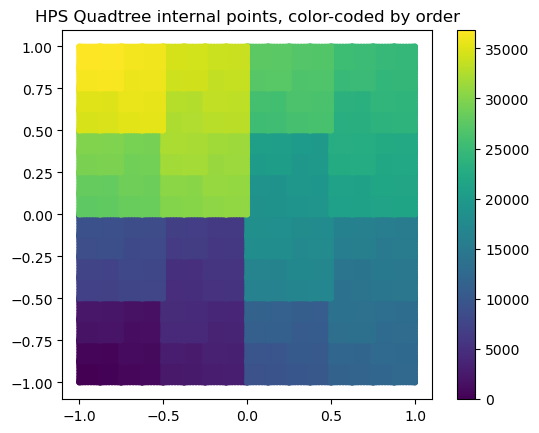

In [12]:
plt.title(f"HPS Quadtree internal points, color-coded by order")
domain_pts = domain.interior_points
plt.scatter(*domain_pts.reshape(-1,2).T, s=10, c=jnp.arange(domain_pts.size//2))
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

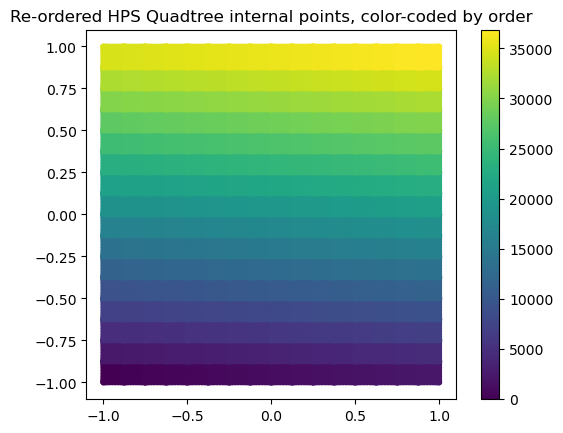

In [13]:
plt.title(f"Re-ordered HPS Quadtree internal points, color-coded by order")
reordered_domain_pts = jnp.take(domain.interior_points, quadtree_to_unrolled_idcs, axis=0)
plt.scatter(*reordered_domain_pts.reshape(-1,2).T, s=10, c=jnp.arange(reordered_domain_pts.size//2))
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

In [20]:
%time
# 1. Reorder the leaf nodes
reordered_leaves_uscat_cheb = jnp.take(uscat_soln, quadtree_to_unrolled_idcs, axis=0)
# 2. Perform the leaf-level operations
reordered_leaves_uscat_unif = jnp.einsum(
    "jl,il...->ij...",
    interp_leaf_cheb_to_unif,
    reordered_leaves_uscat_cheb
)
# 3. Reshape the leaf-level data into square matrices
# Why did I have to flip the two leaf dimensions???
my_uscat_unif = (
    reordered_leaves_uscat_unif
    .reshape(2**L, 2**L, n_per_leaf, n_per_leaf, *reordered_leaves_uscat_unif.shape[2:])
    .transpose(0,3,1,2, *(jnp.arange(4,2+reordered_leaves_uscat_unif.ndim)))
    # [::-1, ::-1, :, :, ...]
    .reshape(2**L * n_per_leaf, 2**L * n_per_leaf, *reordered_leaves_uscat_unif.shape[2:])
)

CPU times: user 12 μs, sys: 1e+03 ns, total: 13 μs
Wall time: 25 μs


In [27]:
# Why does this not match exactly??
orig_unif_interp_err = (
    jnp.linalg.norm(jax.device_put(my_uscat_unif, uscat_regular.device) - uscat_regular)
    / jnp.linalg.norm(uscat_regular)
)
flipped_unif_interp_err = (
    jnp.linalg.norm(jax.device_put(my_uscat_unif[::-1], uscat_regular.device) - uscat_regular) 
    / jnp.linalg.norm(uscat_regular)
)
print(f"Relative error vs uscat_regular (orig):    {orig_unif_interp_err:.5e}")
print(f"Relative error vs uscat_regular (flipped): {flipped_unif_interp_err:.5e}")

Relative error vs uscat_regular (orig):    2.14964e-08
Relative error vs uscat_regular (flipped): 1.36613e+00


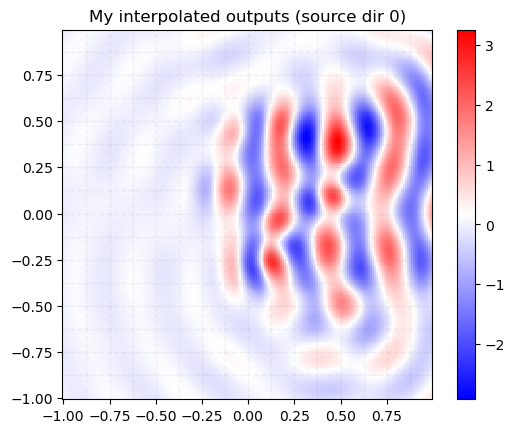

In [22]:
show_leaves = True

fig, ax = plt.subplots(1)
ax.set_title(f"My interpolated outputs (source dir {src_idx})")
cb = ax.pcolormesh(
    grid_unif_x,
    grid_unif_y,
    jnp.real(my_uscat_unif[:, :, src_idx]),
    # jnp.real(my_uscat_unif[::-1,:, src_idx] - jax.device_put(uscat_regular[:,:,src_idx], my_uscat_unif.device)).T,
    cmap="bwr",
)

if show_leaves:
    for li in range(1, 2**L):
        ax.axvline(-1 + 2 * (li/2**L), color="gray", linestyle="dashed", linewidth=1, alpha=0.1)
        ax.axhline(-1 + 2 * (li/2**L), color="gray", linestyle="dashed", linewidth=1, alpha=0.1)
ax.set_aspect(1)
fig.colorbar(cb)
# plt.xlim(jnp.array([0, 48]))
plt.show()

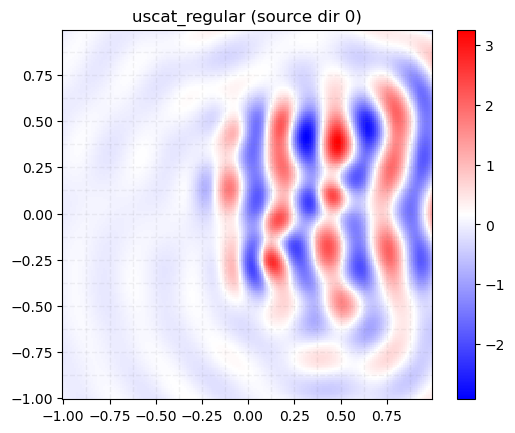

In [23]:
src_idx = 0
show_leaves = True
fig, ax = plt.subplots(1)
ax.set_title(f"uscat_regular (source dir {src_idx})")
cb = ax.pcolormesh(
    xvals_reg[:],
    yvals_reg[:],
    jnp.real(uscat_regular[:, :, src_idx]),
    cmap="bwr",
)
if show_leaves:
    for li in range(1, 2**L):
        ax.axvline(-1 + 2 * (li/2**L), color="gray", linestyle="dashed", linewidth=1, alpha=0.1)
        ax.axhline(-1 + 2 *(li/2**L), color="gray", linestyle="dashed", linewidth=1, alpha=0.1)
ax.set_aspect(1)
fig.colorbar(cb)
plt.show()